<a href="https://colab.research.google.com/github/elainedias16/TCC/blob/main/Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BBC News Dataset

# Reading the Dataset and Creating the Dataframe

In [2]:
import pandas as pd

id_file = '1m41gWGwnLYo0nAEOABnU_MH_SCQHWfjS'
url_file = 'https://drive.google.com/uc?id={}'.format(id_file)

def create_dataframe(path):
    columns=['genre', 'filename', 'title', 'content']
    df =  pd.read_table(
    path,
    header=None,
    names=columns,
    sep= '\t',
    engine= 'python'
    )
    return df


df = create_dataframe(url_file)
df = df.drop(0).reset_index(drop=True)

df.tail()

,genre,filename,title,content
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...
2224,tech,401.txt,Losing yourself in online gaming,"Online role playing games are time-consuming,..."


In [3]:
content_line = df['content'].iloc[2220]
content_line

' BT is introducing two initiatives to help beat rogue dialler scams, which can cost dial-up net users thousands.  From May, dial-up net users will be able to download free software to stop computers using numbers not on a user\'s "pre-approved list". Inadvertently downloaded by surfers, rogue diallers are programs which hijack modems and dial up a premium rate number when users log on. Thousands of UK dial-up users are believed to have been hit by the scam. Some people have faced phone bills of up to £2,000. BT\'s Modem Protection program will check numbers that are dialled by a computer and will block them if they have not been pre-approved, such as national and net service provider numbers. Icstis, the UK\'s premium rate services watchdog, said it had been looking for companies to take the lead in initiatives. "The initiatives are very welcome," a spokesperson from Icstis told the BBC News website. "We are very pleased to see they are putting into place new measures to protect consu

In [4]:
import nltk
nltk.download('punkt')
from nltk import sent_tokenize, word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import spacy
from spacy.lang.en.examples import sentences

!pip install unidecode
import unidecode
from nltk.stem.porter import PorterStemmer
!python -m spacy download en_core_web_sm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 28.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
def remove_non_alphanumeric(text):
    words = ''
    for w in text:
        words += w if w.isalnum() else ' '
    return words

def remove_accents(text):
  return unidecode.unidecode(text)


def lowercasting(tokens):
  tokens = [w.lower() for w in tokens]
  return tokens

def remove_stop_words(tokens):
  stop_words = set(stopwords.words('english')) #List of stop words in english
  tokens = [token for token in tokens if token not in stop_words]
  return tokens


def stemming(tokens):
  porter = PorterStemmer()
  tokens = [porter.stem(token) for token in tokens]
  return tokens


def lemmanization(text):
    nlp = spacy.load("en_core_web_sm")    # Load English language model
    doc = nlp(text)   # Process the text using the Spacy NLP
    tokens = [token.lemma_ for token in doc]
    return tokens


def pre_processing_aux(text):
  words = remove_non_alphanumeric(text)
  words = remove_accents(words)
  tokens = word_tokenize(words)
  tokens = lowercasting(tokens)
  tokens = remove_stop_words(tokens)
  words = ' '.join(tokens)
  tokens = lemmanization(words)
  tokens = stemming(tokens)
  return ' '.join(tokens)


In [6]:
def pre_processing(df):
    df['content'] = df['content'].apply(pre_processing_aux)
    return df

df = pre_processing(df)
df.tail()

,genre,filename,title,content
2220,tech,397.txt,BT program to beat dialler scams,bt introduc two initi help beat rogu dialler s...
2221,tech,398.txt,Spam e-mails tempt net shoppers,comput user across world continu ignor secur w...
2222,tech,399.txt,Be careful how you code,new european direct could put softwar writer r...
2223,tech,400.txt,US cyber security chief resigns,man make sure us comput network safe secur res...
2224,tech,401.txt,Losing yourself in online gaming,onlin role play game time consum enthral fligh...


# Basic statistics analysis

##Documents number by class

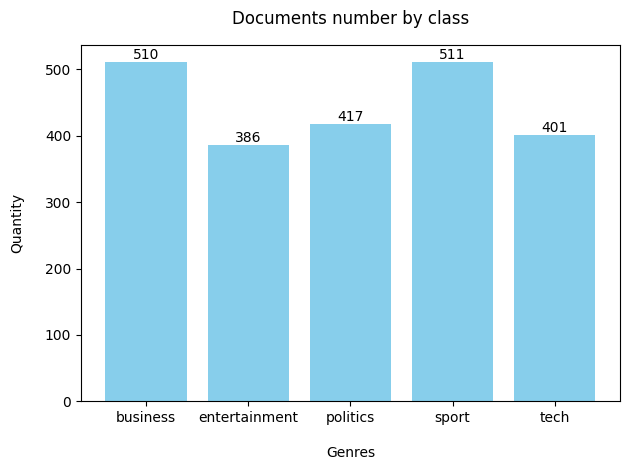

{'business': 510, 'entertainment': 386, 'politics': 417, 'sport': 511, 'tech': 401}


In [134]:
import matplotlib.pyplot as plt
import seaborn

genres = df['genre'].unique()

def qtd_doc_genres():
  qtd_genres = {}
  for genre in genres:
      count = df[df['genre'] == genre]['genre'].count()
      qtd = { genre : count}
      qtd_genres.update(qtd)
  return qtd_genres


def plot_doc_by_class():
  qtd_genres = qtd_doc_genres()
  qtd = qtd_genres.values()

  plt.title('Documents number by class', pad=15)
  plt.xlabel('Genres', labelpad=15)
  plt.ylabel('Quantity', labelpad=15)
  bars = plt.bar(genres , qtd, color='skyblue')
  plt.tight_layout()

  for bar in bars:
      height = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2.0, height, str(height), ha='center', va='bottom')


  plt.show()
  print(qtd_genres)


plot_doc_by_class()

#Top 30 most frequent words

In [160]:
from collections import Counter

def get_genre_content(df, genre):
  content = df.loc[df['genre'] == genre, 'content'].str.cat(sep=' ')
  return content

content_business = get_genre_content(df, 'business')
content_entertainment = get_genre_content(df, 'entertainment')
content_politics = get_genre_content(df, 'politics')
content_sport = get_genre_content(df, 'sport')
content_tech = get_genre_content(df, 'tech')
content_all = content_business + ' ' + content_entertainment + ' ' + content_politics + ' ' + content_sport + ' ' + content_tech

count_business = Counter(content_business.split())
count_entertainment = Counter(content_entertainment.split())
count_politics = Counter(content_politics.split())
count_sport = Counter(content_sport.split())
count_tech = Counter(content_tech.split())
count_all = Counter(content_all.split())

def get_top_n_words(top_n, count_words):
    most_common_words = {}
    for word, count in count_words.most_common(top_n):
        most_common_words[word] = count
    return most_common_words

top_n = 30
common_words_business = get_top_n_words(top_n, count_business)
common_words_entertainment = get_top_n_words(top_n, count_entertainment)
common_words_politics = get_top_n_words(top_n, count_politics)
common_words_sport = get_top_n_words(top_n, count_sport)
common_words_tech = get_top_n_words(top_n, count_tech)
common_words_all = get_top_n_words(top_n, count_all)


def plot_most_common_words(top_n, count_words, title, fontsize):
    top_words = list(count_words.keys())[:top_n]
    top_counts = list(count_words.values())[:top_n]

    plt.figure(figsize=(11, 5))
    bars = plt.bar(top_words, top_counts, color='skyblue')
    plt.xlabel('Tokens', labelpad=15)
    plt.ylabel('Frequency', labelpad=15)
    plt.title(title, pad=15)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    for bar in bars:
        height = bar.get_height() #Capture qtd of each bar
        plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=fontsize)

    plt.show()

fontsize=10

##Top 30 most frequent tokens in business

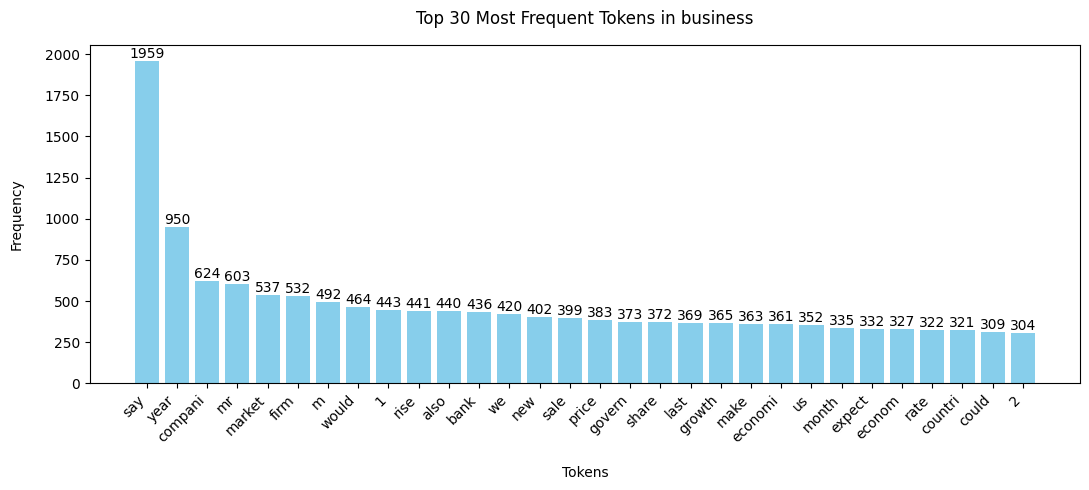

{'say': 1959, 'year': 950, 'compani': 624, 'mr': 603, 'market': 537, 'firm': 532, 'm': 492, 'would': 464, '1': 443, 'rise': 441, 'also': 440, 'bank': 436, 'we': 420, 'new': 402, 'sale': 399, 'price': 383, 'govern': 373, 'share': 372, 'last': 369, 'growth': 365, 'make': 363, 'economi': 361, 'us': 352, 'month': 335, 'expect': 332, 'econom': 327, 'rate': 322, 'countri': 321, 'could': 309, '2': 304}


In [161]:
title_business = 'Top {} Most Frequent Tokens in business'.format(top_n)
plot_most_common_words(top_n, common_words_business, title_business, fontsize)
print(common_words_business)

##Top 30 most frequent tokens in entertainment




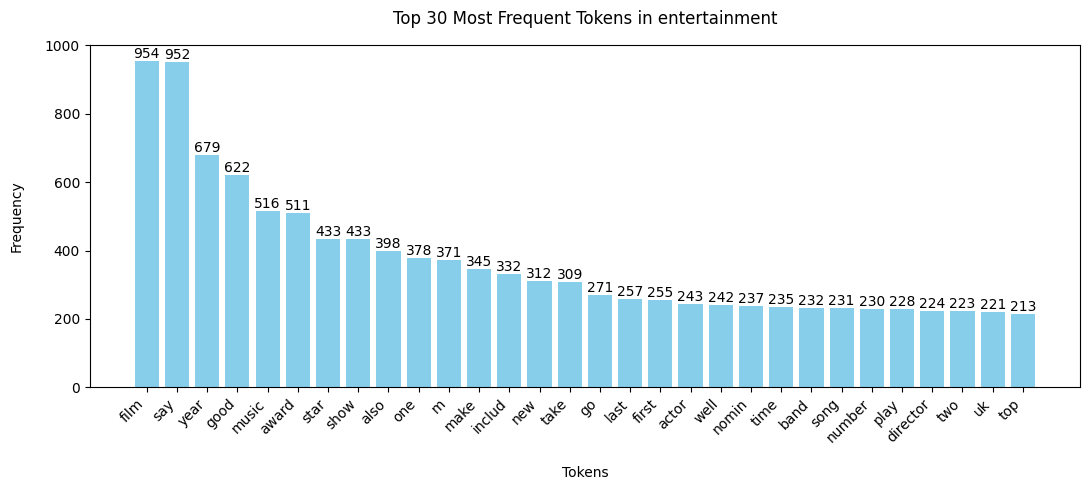

{'film': 954, 'say': 952, 'year': 679, 'good': 622, 'music': 516, 'award': 511, 'star': 433, 'show': 433, 'also': 398, 'one': 378, 'm': 371, 'make': 345, 'includ': 332, 'new': 312, 'take': 309, 'go': 271, 'last': 257, 'first': 255, 'actor': 243, 'well': 242, 'nomin': 237, 'time': 235, 'band': 232, 'song': 231, 'number': 230, 'play': 228, 'director': 224, 'two': 223, 'uk': 221, 'top': 213}


In [162]:
title_entertainment = 'Top {} Most Frequent Tokens in entertainment'.format(top_n)
plot_most_common_words(top_n, common_words_entertainment, title_entertainment, fontsize)
print(common_words_entertainment)

##Top 30 most frequent tokens in politics

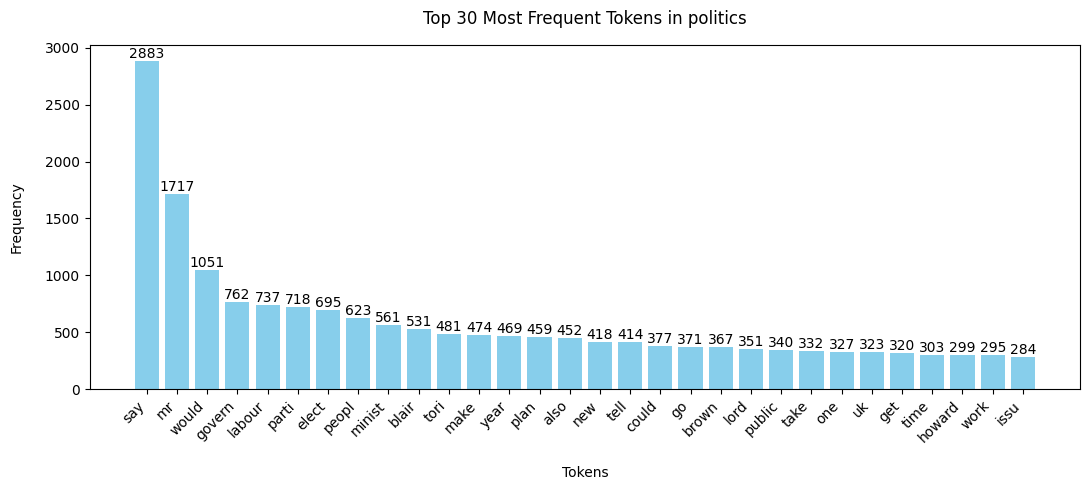

{'say': 2883, 'mr': 1717, 'would': 1051, 'govern': 762, 'labour': 737, 'parti': 718, 'elect': 695, 'peopl': 623, 'minist': 561, 'blair': 531, 'tori': 481, 'make': 474, 'year': 469, 'plan': 459, 'also': 452, 'new': 418, 'tell': 414, 'could': 377, 'go': 371, 'brown': 367, 'lord': 351, 'public': 340, 'take': 332, 'one': 327, 'uk': 323, 'get': 320, 'time': 303, 'howard': 299, 'work': 295, 'issu': 284}


In [163]:
title_politics = 'Top {} Most Frequent Tokens in politics'.format(top_n)
plot_most_common_words(top_n, common_words_politics, title_politics, fontsize)
print(common_words_politics)

##Top 30 most frequent tokens in sport

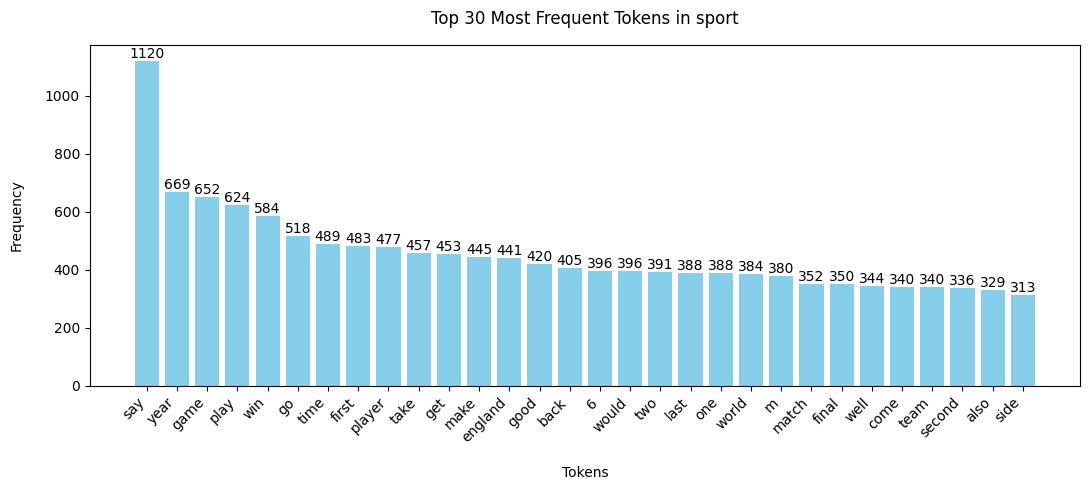

{'say': 1120, 'year': 669, 'game': 652, 'play': 624, 'win': 584, 'go': 518, 'time': 489, 'first': 483, 'player': 477, 'take': 457, 'get': 453, 'make': 445, 'england': 441, 'good': 420, 'back': 405, '6': 396, 'would': 396, 'two': 391, 'last': 388, 'one': 388, 'world': 384, 'm': 380, 'match': 352, 'final': 350, 'well': 344, 'come': 340, 'team': 340, 'second': 336, 'also': 329, 'side': 313}


In [164]:
title_sport = 'Top {} Most Frequent Tokens in sport'.format(top_n)
plot_most_common_words(top_n, common_words_sport, title_sport, fontsize)
print(common_words_sport)

##Top 30 most frequent tokens in tech

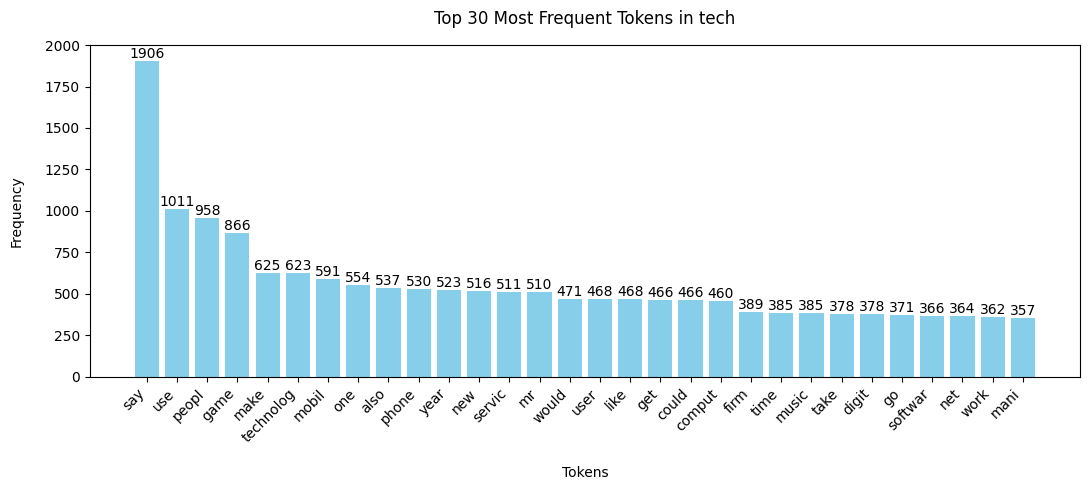

{'say': 1906, 'use': 1011, 'peopl': 958, 'game': 866, 'make': 625, 'technolog': 623, 'mobil': 591, 'one': 554, 'also': 537, 'phone': 530, 'year': 523, 'new': 516, 'servic': 511, 'mr': 510, 'would': 471, 'user': 468, 'like': 468, 'get': 466, 'could': 466, 'comput': 460, 'firm': 389, 'time': 385, 'music': 385, 'take': 378, 'digit': 378, 'go': 371, 'softwar': 366, 'net': 364, 'work': 362, 'mani': 357}


In [165]:
title_tech = 'Top {} Most Frequent Tokens in tech'.format(top_n)
plot_most_common_words(top_n, common_words_tech, title_tech, fontsize)
print(common_words_tech)

##Top 30 most frequent tokens in all dataset

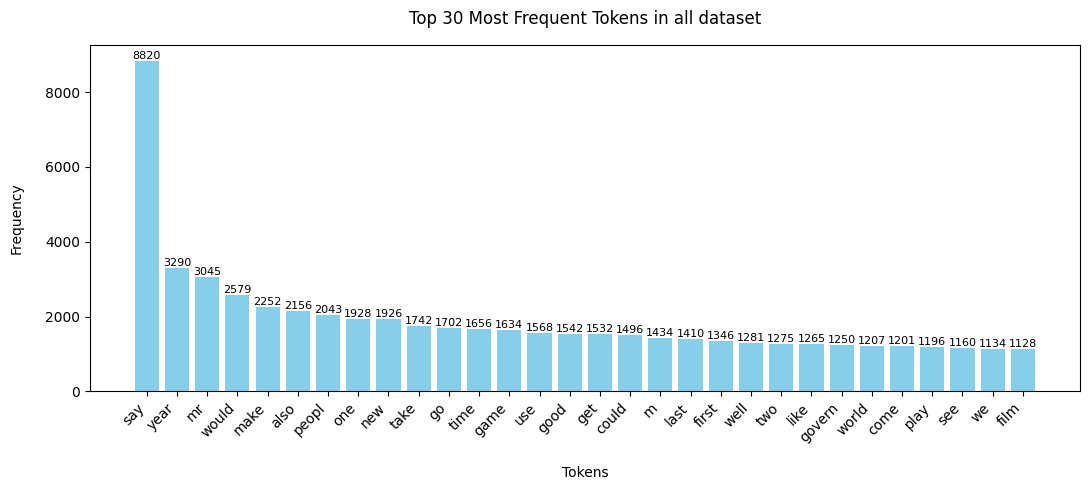

{'say': 8820, 'year': 3290, 'mr': 3045, 'would': 2579, 'make': 2252, 'also': 2156, 'peopl': 2043, 'one': 1928, 'new': 1926, 'take': 1742, 'go': 1702, 'time': 1656, 'game': 1634, 'use': 1568, 'good': 1542, 'get': 1532, 'could': 1496, 'm': 1434, 'last': 1410, 'first': 1346, 'well': 1281, 'two': 1275, 'like': 1265, 'govern': 1250, 'world': 1207, 'come': 1201, 'play': 1196, 'see': 1160, 'we': 1134, 'film': 1128}


In [166]:
fontsize=8
title_all = 'Top {} Most Frequent Tokens in all dataset'.format(top_n)
plot_most_common_words(top_n, common_words_all, title_all, fontsize)
print(common_words_all)

#Frequency of class by word

In [196]:
import random

count_genres = {
  'business': count_business,
  'entertainment' : count_entertainment,
  'politics' : count_politics,
  'sport' : count_sport,
  'tech' : count_tech
}


#Choose 10 random tokens in all content of news
random_words = random.sample(content_all.split(), 3)
print("random words: ", random_words)

def get_counts_per_genre(word, count_genres):
    counts_per_genre = {}  #Dictionary to store word count in each class
    for genre, content_counter in count_genres.items():
        if word in content_counter:
            counts_per_genre[genre] = content_counter[word]  # Adds the word count in the class to the dictionary
    return counts_per_genre


def get_frequency_class_by_word(selected_words, count_genres):
    dict_frequency = {}
    for word in selected_words:
        dict_frequency[word] = get_counts_per_genre(word, count_genres)
    return dict_frequency


dict_frequency = get_frequency_class_by_word(random_words, count_genres)
print(dict_frequency)

random words:  ['simpli', 'rest', 'point']
{'simpli': {'business': 16, 'entertainment': 14, 'politics': 38, 'sport': 20, 'tech': 57}, 'rest': {'business': 23, 'entertainment': 16, 'politics': 27, 'sport': 33, 'tech': 12}, 'point': {'business': 100, 'entertainment': 27, 'politics': 87, 'sport': 174, 'tech': 86}}


## Frequency of words by documents

In [208]:
def get_frequency(df):
    frequency = {}
    for index, row in df.iterrows():
        filename = row['filename']
        word_counts = dict(Counter(row['content'].split()))
        frequency[filename] = word_counts
    return frequency

frequency = get_frequency(df)
print(frequency)
print('------------------')
print(frequency['001.txt'])

{'001.txt': {'kyrgyz': 4, 'republ': 4, 'small': 1, 'mountain': 1, 'state': 1, 'former': 2, 'soviet': 2, 'use': 12, 'invis': 2, 'ink': 24, 'ultraviolet': 3, 'reader': 3, 'countri': 3, 'elect': 15, 'part': 3, 'drive': 2, 'prevent': 1, 'multipl': 1, 'vote': 1, 'new': 1, 'technolog': 2, 'caus': 4, 'worri': 1, 'guard': 1, 'optim': 1, 'among': 2, 'differ': 1, 'sector': 1, 'popul': 2, 'effort': 2, 'live': 1, 'reput': 1, '1990': 2, 'island': 1, 'democraci': 1, 'presid': 1, 'askar': 1, 'akaev': 1, 'push': 2, 'law': 2, 'requir': 1, 'upcom': 2, 'parliamentari': 3, 'presidenti': 2, 'us': 1, 'govern': 3, 'agre': 1, 'fund': 1, 'expens': 1, 'associ': 2, 'decis': 1, 'see': 1, 'mani': 2, 'expert': 1, 'backslid': 1, 'high': 1, 'point': 1, 'reach': 1, 'mid': 1, 'hastili': 1, 'referendum': 1, '2003': 1, 'reduc': 1, 'legisl': 1, 'branch': 1, 'one': 4, 'chamber': 1, '75': 1, 'deputi': 1, 'gener': 1, 'show': 3, 'commit': 1, 'toward': 2, 'open': 1, 'german': 1, 'embassi': 1, 'soro': 1, 'foundat': 1, 'contribu